In [1]:
TRANSCRIPTS_DIR = "./transcripts"
EMBEDDINGS_DIR = "./embeddings"
ATTEMPTS_DIR = "./attempts"

### Task 1

Full prompt can be found in prompt.py and query.py

In [3]:
import os
import random
import anthropic
from query import query_llm

os.environ['ANTHROPIC_API_KEY'] = 'API_KEY_HERE'

filepath = random.choice(os.listdir(TRANSCRIPTS_DIR)) # Pick random transcript, assuming 10 total episodes
print(f"Finding arcs for episode {filepath.split('.')[0]}...")

llm_response = query_llm(os.path.join(TRANSCRIPTS_DIR, filepath), anthropic.Anthropic())
print(f"\n{llm_response}")


Finding arcs for episode s01e09...

Here is the JSON response with the extracted story arcs:

{
  "story_arcs": [
    {
      "label": "Supreme Court Nomination",
      "description": "The White House is working to nominate a new Supreme Court justice to replace the retiring Justice Crouch.",
      "characters": [
        "President Bartlet",
        "Leo McGarry",
        "Josh Lyman",
        "Toby Ziegler",
        "Sam Seaborn",
        "C.J. Cregg",
        "Mandy Hampton",
        "Donna Moss",
        "Justice Crouch",
        "Judge Peyton Cabot Harrison III",
        "Judge Roberto Mendoza"
      ],
      "themes": [
        "Judicial Appointments",
        "Constitutional Interpretation",
        "Vetting Process"
      ]
    },
    {
      "label": "Drug Use Allegations",
      "description": "Congressman Lillienfield makes accusations that White House staffers regularly use illegal drugs, causing a crisis for the administration.",
      "characters": [
        "Josh Lyman",

### Task 2

The theory and inner workings of the evals are explained in evals_theory.ipynb, along with some control experiments for interpretability.

In [5]:
# Level 0 Evals: Validate the Output Format
import re
from evals import level_0_evals

files = os.listdir(ATTEMPTS_DIR)
scores = [0.0] * 10 # score[i] = average score for episode i
episodes = [[] for _ in range(10)] # episodes[i] is a list of all valid json arcs extracted for episode i across all attempts

for file in files:
    episode = int(re.search(r'ep(\d+)', file).group(1)) # Pattern to find 'ep' followed by digits
    with open(os.path.join(ATTEMPTS_DIR, file), "r") as file:
        response = file.read()
    valid, json_arcs = level_0_evals(response)
    if valid:
        scores[episode-1] += 1
        episodes[episode-1].append((json_arcs, file.name)) # Save filename for visibility in what is happening later in the pipeline
scores = [score/10 for score in scores] # Assuming 10 attempts per episode, to generalize keep a count array

print(f"Level 0 Scores per Episode: {scores}")
print(f"Level 0 Score Total: {sum(scores)/len(scores)}")

Level 0 Scores per Episode: [0.8, 1.0, 1.0, 1.0, 0.0, 0.6, 1.0, 0.2, 1.0, 0.9]
Level 0 Score Total: 0.75


In [6]:
# Level 1 Evals: Validate Model's Understanding of Scripts
from evals import level_1_evals

level_1_scores = [0.0] * 10 # Assuming 10 episodes

for episode_index, episode_attempts in enumerate(episodes):
    transcript_filepath = f"s01e{episode_index+1:02d}.txt"
    print(f"Episode {episode_index+1}:")
    episode_score_sum = 0.0
    for attempt_index, (attempt, filename) in enumerate(episode_attempts):
        score = level_1_evals(attempt, os.path.join(TRANSCRIPTS_DIR, transcript_filepath), EMBEDDINGS_DIR)
        episode_score_sum += score
        print(f"\tattempt: {attempt_index}, score: {score:.02f}, reference file: {filename}")
    level_1_scores[episode_index] = episode_score_sum / (attempt_index + 1)

Episode 1:
	attempt: 0, score: 1.20, reference file: ./attempts/ep1_attempt_7.txt
	attempt: 1, score: 0.67, reference file: ./attempts/ep1_attempt_6.txt
	attempt: 2, score: 0.75, reference file: ./attempts/ep1_attempt_4.txt
	attempt: 3, score: 0.75, reference file: ./attempts/ep1_attempt_5.txt
	attempt: 4, score: 0.67, reference file: ./attempts/ep1_attempt_1.txt
	attempt: 5, score: 0.50, reference file: ./attempts/ep1_attempt_3.txt
	attempt: 6, score: 0.25, reference file: ./attempts/ep1_attempt_8.txt
	attempt: 7, score: 0.75, reference file: ./attempts/ep1_attempt_9.txt
Episode 2:
	attempt: 0, score: 2.00, reference file: ./attempts/ep2_attempt_2.txt
	attempt: 1, score: 1.00, reference file: ./attempts/ep2_attempt_3.txt
	attempt: 2, score: 2.00, reference file: ./attempts/ep2_attempt_1.txt
	attempt: 3, score: 2.00, reference file: ./attempts/ep2_attempt_0.txt
	attempt: 4, score: 2.00, reference file: ./attempts/ep2_attempt_4.txt
	attempt: 5, score: 2.00, reference file: ./attempts/ep

In [7]:
print(f"Level 1 Scores per Episode: {[round(score, 2) for score in level_1_scores]}")
print(f"Level 1 Score Total: {sum(level_1_scores)/len(level_1_scores):.2f}")
print(f"\nFinal Prompt Score: {sum(scores)/len(scores) * sum(level_1_scores)/len(level_1_scores):.2f}")

Level 1 Scores per Episode: [0.69, 9.7, 0.93, 7.78, 0.0, 5.67, 1.18, 2.38, 0.47, 1.26]
Level 1 Score Total: 3.01

Final Prompt Score: 2.25


Some insights gained:
 - which transcript we use tends to have a large impact on the metrics (i.e. this prompt always fails on transcript 5)
 - there is lots of variability in the number of embeddings within a certain threshold (i.e. the score), normalization might be helpful here
 - different methods of chunking the input could also help with the variability in score, as currently it's done very primitively
 - prompt structure generally performs well, but the major json inconsistency is not having commas in between the list objects (parsing for this or using something like gpt's response format could help)

Some of this "insight" gather process was used to tune the different knobs used in coming up with these scores. More explained in evals_theory.ipynb.

### Task 3

In [8]:
# List of highest scoring response from each episode (9 total because episode 5 has no properly-structured results)
filespaths = [
    "./attempts/ep1_attempt_9.txt",
    "./attempts/ep2_attempt_9.txt",
    "./attempts/ep3_attempt_1.txt",
    "./attempts/ep4_attempt_6.txt",
    "./attempts/ep6_attempt_6.txt",
    "./attempts/ep7_attempt_8.txt",
    "./attempts/ep8_attempt_5.txt",
    "./attempts/ep9_attempt_1.txt",
    "./attempts/ep10_attempt_4.txt"
]

# First, extract the themes from the above response files
from cluster import get_themes
all_themes, themes_dict, characters_dict = get_themes(filespaths)

# all_themes --> key: theme, value: list of characters
# characters_dict --> key: character, value: list of themes

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


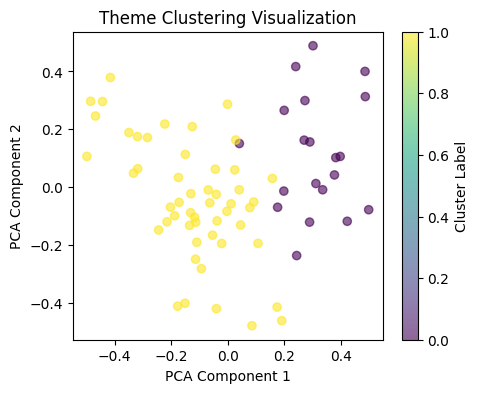

Clusters: {1: ['political dynamics', 'religious influence in politics', 'compromise and negotiation', 'personal integrity', 'ethical dilemmas', 'leadership', 'transparency and accountability', 'humanitarian concerns', 'interagency coordination', 'abuse of power', 'geopolitical tensions', 'moral dilemmas in leadership', 'proportional response', 'consequences of military action', 'ethics and morality in government', 'reputation and public perception', 'diversity in the white house', 'political tensions', 'threats against the president', 'gun control', 'legislation', 'politics', 'negotiation', 'compromise', 'ethics', 'transparency', 'conflict of interest', 'constitutional interpretation', 'partisan politics', 'government efficiency', 'security and protection', 'labor relations', 'political negotiation', 'civil liberties', 'use of force', 'international relations', 'diplomacy', 'personal ethics', 'executive power', 'crisis management', 'power dynamics', 'political rivalry', 'overachievemen

In [9]:
import warnings
from sentence_transformers import SentenceTransformer
from cluster import cluster_and_visualize

warnings.filterwarnings("ignore")
model = SentenceTransformer('all-MiniLM-L6-v2')

# Second, cluster and visualize the clusters
clusters = cluster_and_visualize(all_themes, model)
print(f"Clusters: {clusters}")

Why n=2 clusters were chosen:

Three metrics were considered: silhouette score, davies-bouldin index, and calinski-harabasz index. The davies-bouldin index emphasizes minimizing overlaps in the clusters, which might not be the best fit for clusting episode themes that could be very similar (since they come from the same TV show). The silhouette score captures (1) consistency within clusters and (2) differentiation between clusters. This is better, but differentiation between clusters may again not be the best metric in clustering similar themes. Therefore, most weightage was given to the calinski-harabaz index, which provides a balance between the two. 

The next code block plots these metrics as we change the number of clusters (n) from 1 to 10.

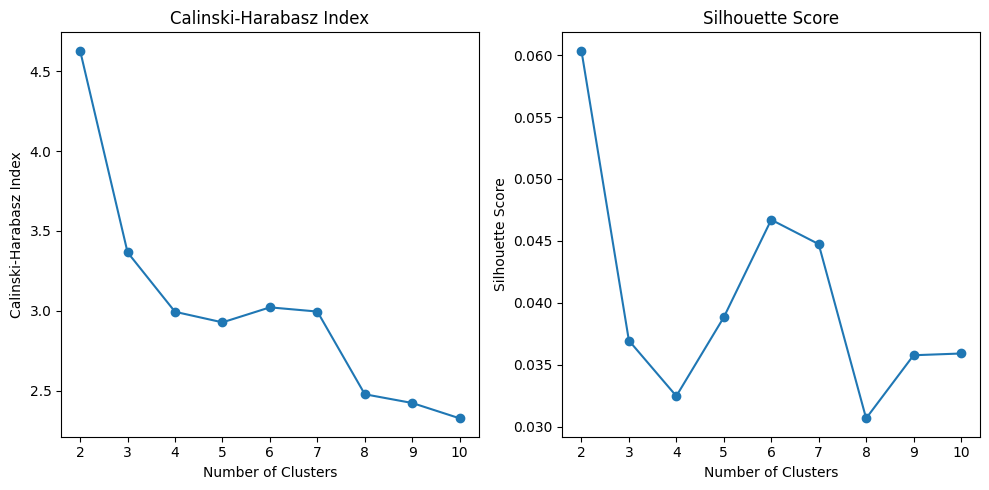

In [10]:
# Evaluate and plot clustering metrics from n=1 to 10

from cluster import evaluate_metrics
evaluate_metrics(all_themes, model)

The CH index is significantly better with n=2 clusters and this seems to visually be the case as well in the clusters plotted above.
If we are considering the silhouette score, we can see that 2 clusters is also one of the better choices of n.

If interested, "./gpt_cluster_analysis.txt" contains ChatGPT's analysis of how well the themes were semantically clustered. Just something I found interesting.

In [11]:
# Determine which characters show up in which cluster

# According to ChatGPT's analysis,
#   cluster 1 -> personal and social themes
#   cluster 2 -> political and governmental themes

from cluster import character_cluster_analysis
character_cluster_analysis(characters_dict, clusters)

josh lyman           | mostly in cluster 2 | percentage:  63.64%
mary marsh           | mostly in cluster 2 | percentage: 100.00%
john van dyke        | mostly in cluster 2 | percentage: 100.00%
al caldwell          | mostly in cluster 2 | percentage: 100.00%
sam seaborn          | mostly in cluster 2 | percentage:  70.59%
laurie               | mostly in cluster 2 | percentage:  60.00%
president bartlet    | mostly in cluster 2 | percentage:  73.68%
leo mcgarry          | mostly in cluster 2 | percentage:  73.91%
c.j. cregg           | mostly in cluster 2 | percentage:  76.92%
toby ziegler         | mostly in cluster 2 | percentage:  76.47%
admiral fitzwallace  | mostly in cluster 2 | percentage:  66.67%
charlie young        | found equally in each cluster
bertram coles        | mostly in cluster 2 | percentage: 100.00%
bartlet              | mostly in cluster 2 | percentage:  78.26%
leo                  | mostly in cluster 2 | percentage:  68.42%
josh                 | mostly in clus